In [16]:
from tensorflow.keras.layers import Conv2D, Dense
from tensorflow.keras.models import Sequential
import numpy as np
import tensorflow as tf
import torch

import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib notebook

# Helper Functions

## create_random_input

Creates a random input vector in the desired shape. The numbers are between 0 and size / 128.

**Input Parameters**
* shape -- The desired shape

**Output Parameters**
* The desired tensor

## ref_conf2d

The reference Conv2D implementation from TensorFlow. 

**Input Parameters**
* X -- The input tensor
* w -- The weights
* b -- The bias
* kernel_size -- The kernel size (kernel_rows, kernel_cols)
* strides -- The strides (stride_rows, stride_cols)
* padding -- "valid" for no padding, "same" for zero padding
* groups -- The number of desired groups

**Output Parameters**
* The result tensor of the convolution

## check_conv2d

Checks an input function with the given parameters against the reference implementation of TensorFlow. 

**Input Parameters**
* fn -- The function to compare to
* shape -- The shape to test the function with
* kernel_size -- The kernel size (kernel_rows, kernel_cols) 
* filters -- The number of filters to use
* strides -- The strides (stride_rows, stride_cols)
* padding -- "valid" for no padding, "same" for zero padding
* groups -- The number of desired groups

**Output Parameters**
* True if the function produces the same output as the reference, False otherwise

## Important Note

Due to floating point inaccuracies (hopefully), the results are not equal but close instead. 

In [17]:
def create_random_input(shape):
    num_elements = np.prod(shape)
    return np.random.randint(0, num_elements, num_elements).astype(np.float32).reshape(shape) / 128.0

def ref_conv2d(X, w, b, kernel_size, strides, padding, groups):
    return Conv2D(input_shape=X.shape, weights=[w, b], kernel_size=kernel_size, filters=w.shape[3], strides=strides, padding=padding, groups=groups)(X).numpy()
    
def check_conv2d(fn, shape, kernel_size, filters, strides, padding, groups=1):
    np.random.seed(3)
    X = create_random_input(shape)
    w = create_random_input((kernel_size[0], kernel_size[1], shape[3], filters))
    b = create_random_input((filters,))
    
    ref = ref_conv2d(X, w, b, kernel_size, strides, padding, groups)
    res = fn(X, w, b, kernel_size, strides, padding, groups)
    
    return np.allclose(res, ref)

# Conv2D Implementation

The actual Conv2D implementation. This function has the same input and output parameters as the ref_conv2d function. 

In [12]:
def res_conv2d(X, w, b, kernel_size, strides, padding, groups=1):
    # extract parameters
    (kernel_rows, kernel_cols, channels_in, channels_out) = w.shape
    (batch, rows_in, cols_in, channels_in_) = X.shape
    grouped_channels_out = channels_out//groups
    
    # check parameter compatibility
    assert channels_in * groups == channels_in_
    assert channels_out % groups == 0
    
    # same padding
    if padding == "same":
        rows_offset = kernel_rows//2
        cols_offset = kernel_cols//2
    
        # calculate output dimensions
        rows_out = (rows_in + strides[0] - 1) // strides[0]
        cols_out = (cols_in + strides[1] - 1) // strides[1]
        
    
        # create output buffer
        out = np.zeros((int(batch), int(rows_out), int(cols_out), int(groups*channels_out)))

        # prefill the output with bias
        for i in range(batch):
            for y in range(rows_out):
                for x in range(cols_out):
                    for g in range(groups):
                        gc = g * grouped_channels_out
                        for co in range(grouped_channels_out):
                            out[i, y, x, gc + co] = b[co]

        # convolute
        for i in range(batch):
            for y in range(rows_out):
                for x in range(cols_out):
                    sy = y * strides[0] - rows_offset
                    sx = x * strides[1] - rows_offset
                    for g in range(groups):
                        for co in range(grouped_channels_out):
                            for ci in range(channels_in):
                                for ky in range(sy, sy + kernel_rows):
                                    for kx in range(sx, sx + kernel_cols):
                                        if ky >= 0 and ky < rows_in and kx >= 0 and kx < cols_in:
                                            gc = g * grouped_channels_out
                                            out[i, y, x, gc + co] += X[i, ky , kx, gc + ci] * w[(ky - sy), (kx - sx), ci, co]

        return out
    
    # zero padding
    else:
        rows_out = (rows_in - (kernel_rows - strides[0])) // strides[0]
        cols_out = (cols_in - (kernel_cols - strides[1])) // strides[1]
        
    
        # create output buffer
        out = np.zeros((int(batch), int(rows_out), int(cols_out), int(groups*channels_out)))

        # prefill the output with bias
        for i in range(batch):
            for y in range(rows_out):
                for x in range(cols_out):
                    for g in range(groups):
                        gc = g * grouped_channels_out
                        for co in range(grouped_channels_out):
                            out[i, y, x, gc + co] = b[co]

        # convolute
        for i in range(batch):
            for y in range(rows_out):
                for x in range(cols_out):
                    sy = y * strides[0]
                    sx = x * strides[1]
                    for g in range(groups):
                        for co in range(grouped_channels_out):
                            for ci in range(channels_in):
                                for ky in range(sy, sy + kernel_rows):
                                    for kx in range(sx, sx + kernel_cols):
                                        gc = g * grouped_channels_out
                                        out[i, y, x, gc + co] += X[i, ky , kx, gc + ci] * w[(ky - sy), (kx - sx), ci, co]

        return out

print(check_conv2d(res_conv2d, (2, 128, 128, 4), (3, 3), 5, (1, 1), "same"))
#print(check_conv2d(res_conv2d, (1, 3, 3, 1), (3, 3), 1, (1, 1), "valid"))
#print(check_conv2d(res_conv2d, (1, 4, 4, 1), (1, 1), 1, (1, 1), "valid"))

True


# More Helper Functions

## ref_dense

The reference Conv2D implementation from TensorFlow. 

**Input Parameters**
* X -- The input tensor
* w -- The weights
* b -- The bias

**Output Parameters**
* The result tensor of the convolution

## check_dense

Checks an input function with the given parameters against the reference implementation of TensorFlow. 

**Input Parameters**
* fn -- The function to compare to
* units -- The dimension of the output
* shape -- The shape to test the function with

**Output Parameters**
* True if the function produces the same output as the reference, False otherwise

In [28]:
def ref_dense(X, w, b):
    return Dense(w.shape[1], input_shape=X.shape, weights=[w, b])(X).numpy()
    
def check_dense(fn, units, shape):
    np.random.seed(3)
    shape = np.array(shape)
    size = np.prod(shape[1:])
    
    X = create_random_input((shape[0], size))
    w = create_random_input((size, units))
    b = create_random_input((units))
    
    ref = ref_dense(X, w, b)
    res = fn(X, w, b)
    
    #return (res == ref).all()
    return np.allclose(res, ref)

# Dense Layer Implementation

The actual dense layer implementation. This function has the same input and output parameters as the ref_dense function. 

<IPython.core.display.Javascript object>


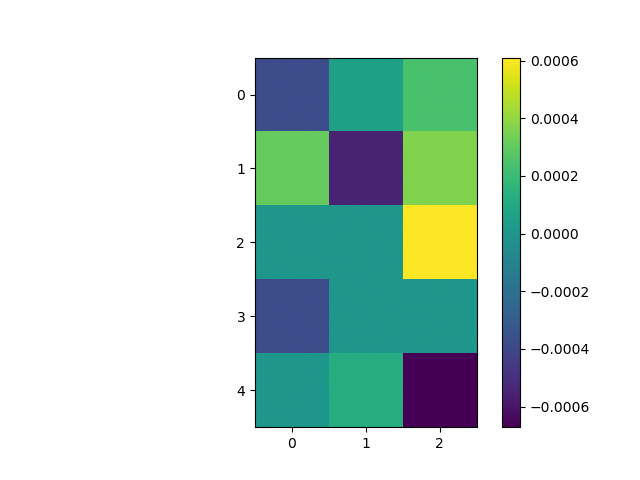

False


In [41]:
def res_dense(X, w, b):
    # extract parameters
    (batches, size) = X.shape
    (w_s, units) = w.shape
    
    # check parameter compatibility
    assert size == w_s
    
    # create output buffer
    out = np.zeros((batches, units))
        
    # prefill output with bias
    for i in range(batches):
        for j in range(units):
            out[i, j] = b[j]
    
    # matrix multiplikation
    for i in range(batches):
        for j in range(units):
            for k in range(size):
                out[i, j] += X[i, k] * w[k, j]
                
    return out

print(check_dense(res_dense, 3, (5, 256)))